In [1]:
## Dataset is from COCO 2017 Val Images
# train images: http://images.cocodataset.org/zips/train2017.zip
# val images: http://images.cocodataset.org/zips/val2017.zip
# annoations: http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Source Code
The source code used to generate the paper is found below

In [1]:
# Machine Learning Imports
import torch
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torchvision

# Standard Imports
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# Getting Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

# Dataset
The following code helps load the data downloaded from  Dataset is from COCO 2017 Val Images

**val images**: http://images.cocodataset.org/zips/val2017.zip

**annoations**: http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [2]:
def get_data():
    """
    Gets the Data for the assignment. It reads the data from COCO val2017 
    and constructs an array with the following format

    [
        {'img_name': str - XXX.png, 'text': str },
        ...
    ]
    """
    # reading metadata    
    with open('data/val2017/annotations/captions_val2017.json') as f:
        captions = json.load(f)

    with open('data/annotations/instances_val2017.json') as f:
        inst = json.load(f)

    # getting text mappings
    id2text = {d['image_id']: d['caption'] for d in captions['annotations']}

    id2cat = {}
    for d in inst['annotations']:
       
        id2cat[d['image_id']]  = d['category_id']
    
    
    data = []
    for d in captions['images']:
        # buggy data
        if d['id'] in [61418, 24021, 141671, 431848, 274219, 353180, 209222, 130465, 7888, 205289]:
            continue
        
        if d['id'] not in list(id2text.keys()):
            continue

        if d['id'] not in list(id2cat.keys()):
            continue

        data.append({'img_name': d['file_name'], 'text': id2text[d['id']], 'id': d['id'], 'category': id2cat[d['id']]})
    return data
    

In [3]:
# Gets data
data = get_data()

Text(0.5, 1.0, 'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.')

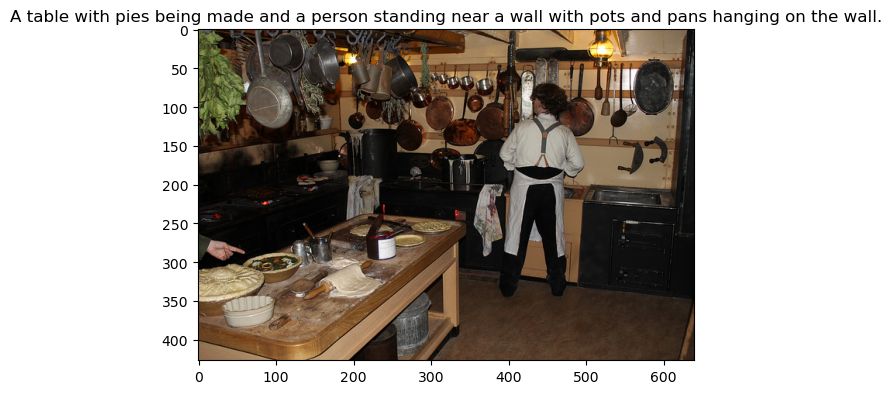

In [5]:
## Example plot
idx = 0
img_path = os.path.join('data/val2017/images', data[idx]['img_name'])
img, text = torchvision.io.read_image(img_path), data[idx]['text']

plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(text)

# Model 
## Implementation
Here is the dataloader and VAE implementation. All of it uses pytorch

In [4]:
# --------- Dataloaders ---------
class TextToImageDataset(Dataset):
    """Text To Image Dataset"""

    def __init__(self, data):
        self.data = data
        self.image_dir = 'data/val2017/images'
        self.transform = torchvision.transforms.Resize([256, 256])
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data[idx]['img_name'])
        
        img, text, category = torchvision.io.read_image(img_path), self.data[idx]['text'], self.data[idx]['category']

        return self.transform(img)/256, text, category

# --------- Model ---------

class TextToImageModel(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: list = None,
                 **kwargs) -> None:
        super(TextToImageModel, self).__init__()

        self.latent_dim = latent_dim
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [8, 12, 16, 24, 32]

        self.img_dim  = int(256/2**len(hidden_dims))
        self.final_dim = hidden_dims[-1]

        # --------- Image encoder ---------
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*self.img_dim*self.img_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*self.img_dim*self.img_dim, latent_dim)


        # --------- Decode r---------
        modules = []
    
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.img_dim * self.img_dim)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

        # --------- Text Encoder ---------
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        hidden_size = 768

        self.multi_head_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=3, batch_first=True)

        self.text_encoder = nn.Sequential(
            nn.Linear(hidden_size, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        

    def encode(self, input: Tensor) -> Tensor:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(z.shape[0], self.final_dim, self.img_dim, self.img_dim)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def freeze_decoder(self):
        for param in self.decoder_input.parameters():
            param.requires_grad = False
        
        for param in self.decoder.parameters():
            param.requires_grad = False
        
        for param in self.final_layer.parameters():
            param.requires_grad = False


    def text_encode(self, sentences) -> Tensor:
        encoding = self.tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=64)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']

        
        # Pass through BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Multi-head attention
        attn_output, _ = self.multi_head_attention(sequence_output, sequence_output, sequence_output)
        
        # Mean Pool
        aggregated = torch.mean(attn_output, dim=1) 
        
        # Pass through MLP
        mlp_output = self.text_encoder(aggregated)
        
        return mlp_output

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self, recons, inputs, mu, log_var) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        kld_weight = inputs.shape[0] 
        recons_loss = F.mse_loss(recons, inputs)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}


def progress_bar(iteration, total, loss = 0, decimals=1, length=50, fill='='):
    """
    Create a custom progress bar using only print statements.
    """
    percent = f"{100 * (iteration / float(total)):.{decimals}f}"
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{iteration}/{total} |{bar}| {percent}% \t loss: {loss}', end='')
    if iteration == total:
        print()

## Training 

In [5]:
## Model Set up
dataloader = DataLoader(TextToImageDataset(data), batch_size = 1, shuffle=True)
model = TextToImageModel(in_channels = 3, latent_dim = 64)

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# ------------ Training Image Model ------------
# hyperparameters
lr = 1e-3
num_epochs=10

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    count = 0

    print(f'epoch: {epoch}/{num_epochs}')
    progress_bar(count, len(dataloader), loss = 0)
 
    for inputs, text, _ in dataloader:
        inputs = inputs.to(device).to(torch.float32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        recons, inputs, mu, log_var = model(inputs)
        loss = model.loss_function(recons, inputs, mu, log_var)
        epoch_loss.append(loss['loss'].item())

        # Backward pass and optimization
        loss['loss'].backward()
        optimizer.step()
        count += 1
        progress_bar(count, len(dataloader), loss = np.mean(epoch_loss))


torch.save(model.state_dict(), 'model_image.pth')

epoch: 0/10
4942/4942 |==================================================| 100.0% 	 loss: 0.26212096402151365
epoch: 1/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07384524372180549
epoch: 2/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07359218791506744
epoch: 3/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07345682792378742
epoch: 4/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07324633674324087
epoch: 5/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07313237652505394
epoch: 6/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07306386396137735
epoch: 7/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07304481007880521
epoch: 8/10
4942/4942 |==================================================| 100.0% 	 loss: 0.07298559290285322
epoch: 9/1

In [ ]:
# ------------ Training text Mapper ------------
# hyperparameters
lr = 1e-3
num_epochs=2

model.cpu()
model.freeze_decoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    count = 0

    print(f'epoch: {epoch}/{num_epochs}')
    
    progress_bar(count, len(dataloader), loss = 0)

    for inputs, text, _ in dataloader:    
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        latents = model.text_encode(list(text))
        recons = model.decode(latents)
        loss = F.mse_loss(recons, inputs)
        epoch_loss.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        count += 1
        progress_bar(count, len(dataloader), loss = np.mean(epoch_loss))


epoch: 0/2
4286/4942 |===========================================-------| 86.7% 	 loss: 0.07262540705514202

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# Evalauation

In [6]:
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

## PCA

All the code below is used to generate the PCA visualizations

In [7]:
def pca(data, n_components=2):
    # Center the data
    data_mean = np.mean(data, axis=0)
    centered_data = data - data_mean

    # Compute covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]

    # Project data onto top eigenvectors
    reduced_data = np.dot(centered_data, top_eigenvectors)
    return reduced_data

In [9]:
# Get the first 100 data points
image_encodings = []
text_encodings = []
labels = []

with torch.no_grad():
    for i, (images, texts, category) in enumerate(dataloader):
        # limit only 3 samples from each category due to computation constraints        
        mu, _ = model.encode(images)
        image_latent = mu.squeeze().numpy()
        text_latent = model.text_encode(texts)
        image_encodings.append(image_latent)
        text_encodings.append(text_latent.squeeze().numpy())
        labels.append(category)

/tmp/ipykernel_299/1619204049.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(np.unique(labels)))


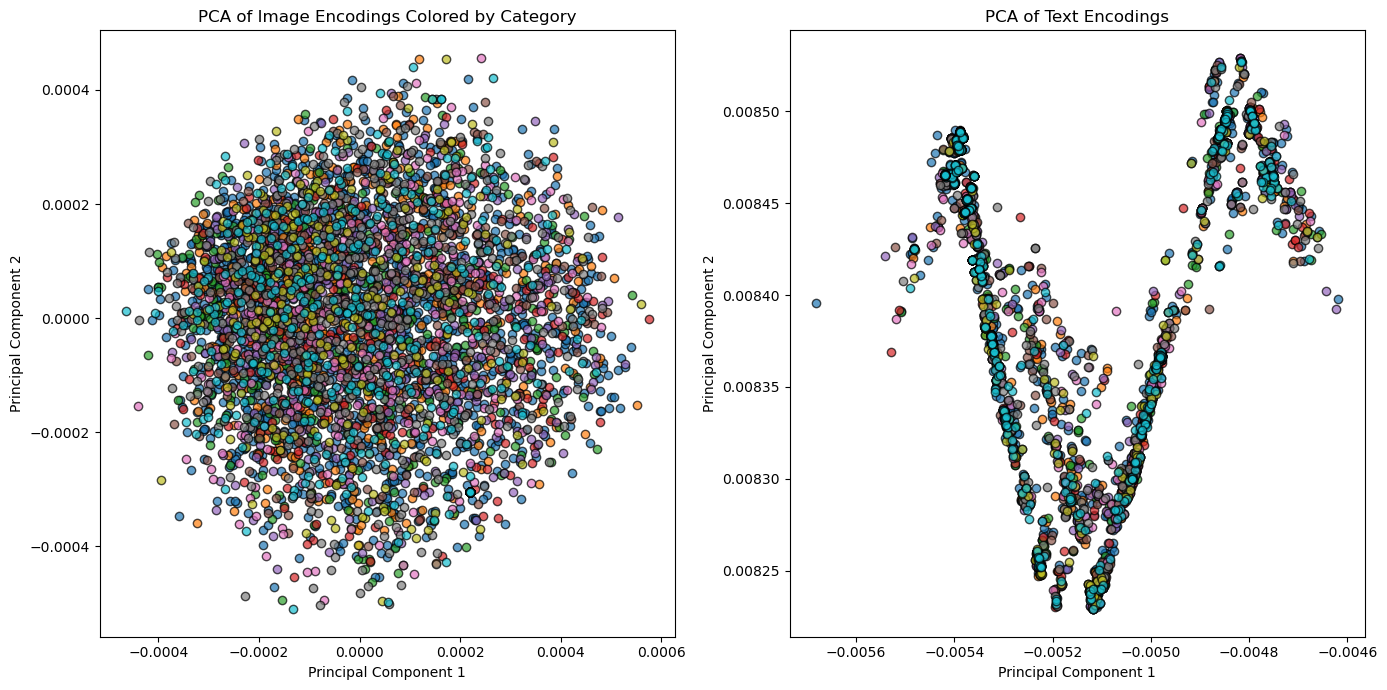

In [11]:
colors = plt.cm.get_cmap("tab10", len(np.unique(labels)))
unique_categories = np.unique(labels)

# Perform PCA on image and text encodings
image_pca = pca(image_encodings)
text_pca = pca(text_encodings)

# Plot PCA results with coloring based on categories
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for i, category in enumerate(unique_categories):
    idx = np.where(labels == category)
    plt.scatter(
        image_pca[idx, 0],
        image_pca[idx, 1],
        label=category,
        c=[colors(i)],
        alpha=0.7,
        edgecolor="k"
    )

plt.title("PCA of Image Encodings Colored by Category")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Category")
plt.legend('',frameon=False)

# Text PCA plot
plt.subplot(1, 2, 2)
for i, category in enumerate(unique_categories):
    idx = np.where(labels == category)
    plt.scatter(
        text_pca[idx, 0],
        text_pca[idx, 1],
        label=category,
        c=[colors(i)],
        alpha=0.7,
        edgecolor="k"
    )
plt.title("PCA of Text Encodings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend('',frameon=False)

plt.tight_layout()
plt.show()

## Kohonen Feature Map
All the code below is used to generate the Kohonen Feature Map visualizations

In [26]:
class KohonenMap:
    def __init__(self, dimensions: list, input_dim: int, learning_rate: float =0.1, radius: float =1.0):
        """
        dimensions: Tuple (width, height) of the SOM grid.
        input_dim: Dimensionality of input data.
        learning_rate: Initial learning rate for weight updates.
        radius: Initial neighborhood radius.
        """
        self.width, self.height = dimensions
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.radius = radius
        self.weights = np.random.rand(self.width, self.height, self.input_dim)  # Initialize random weights

    def find_best_matching_unit(self, input_vector):
        """Find the best matching unit (BMU) for a given input vector."""
        distances = np.linalg.norm(self.weights - input_vector, axis=-1)
        return np.unravel_index(np.argmin(distances), (self.width, self.height))

    def update_weights(self, input_vector, bmu, iteration, max_iterations):
        """Update weights of the SOM based on the input vector and BMU."""
        learning_rate = self.learning_rate * np.exp(-iteration / max_iterations)
        radius = self.radius * np.exp(-iteration / max_iterations)

        for x in range(self.width):
            for y in range(self.height):
                distance_to_bmu = np.linalg.norm(np.array([x, y]) - np.array(bmu))
                if distance_to_bmu <= radius:
                    influence = np.exp(-(distance_to_bmu**2) / (2 * (radius**2)))
                    self.weights[x, y] += influence * learning_rate * (input_vector - self.weights[x, y])

    def train(self, data, num_iterations):
        """Train the SOM on the given dataset."""
        for iteration in range(num_iterations):
            for input_vector in data:
                bmu = self.find_best_matching_unit(input_vector)
                self.update_weights(input_vector, bmu, iteration, num_iterations)

    def visualize_2d_weights(self, title):
        """Visualize the first two dimensions of the SOM weights as a 2D scatter plot."""
        weight_vectors = self.weights.reshape(-1, self.input_dim)
        plt.figure(figsize=(8, 8))
        plt.scatter(weight_vectors[:, 0], weight_vectors[:, 1], c='blue', s=10)
        plt.title(f"{title} SOM Feature Map")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.grid()
        plt.show()

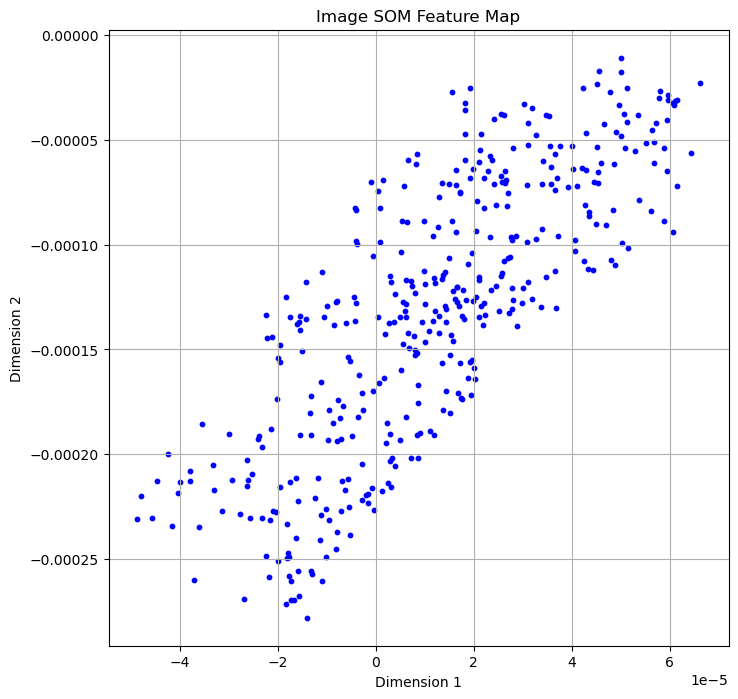

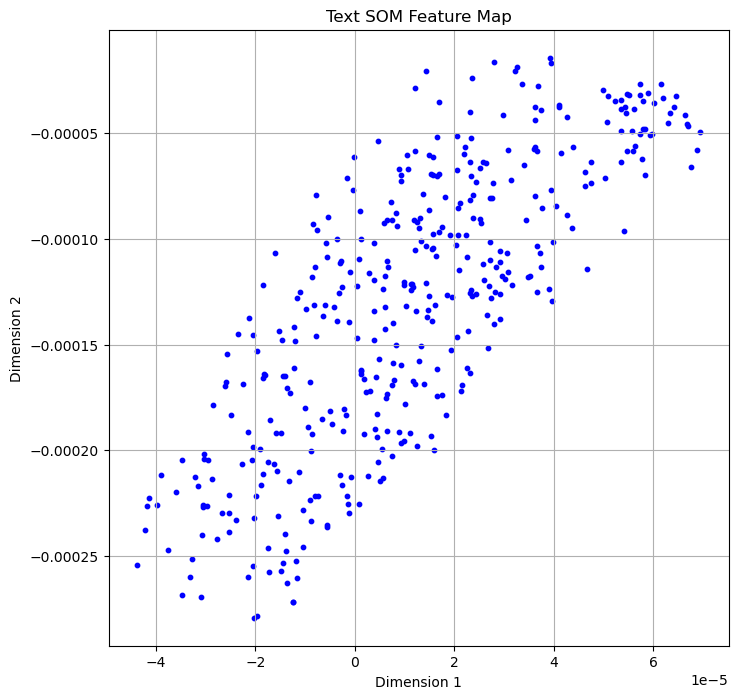

In [27]:
# Example usage
# Assuming `image_encodings` is a list of numpy arrays representing encoded images
image_encodings = np.array(image_encodings)
text_encodings = np.array(text_encodings) 

# Initialize and train the Kohonen map
som = KohonenMap(dimensions=(20, 20), input_dim=64, learning_rate=0.5, radius=5.0)
som.train(image_encodings, num_iterations=100)

# Visualize the first two dimensions of the SOM weights
som.visualize_2d_weights(title = "Image")

# Initialize and train the Kohonen map
som = KohonenMap(dimensions=(20, 20), input_dim=64, learning_rate=0.5, radius=5.0)
som.train(image_encodings, num_iterations=100)

# Visualize the first two dimensions of the SOM weights
som.visualize_2d_weights(title = "Text")


# The End